In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import math
import copy
import matplotlib.pyplot as plt
import wandb
import os

## Load data

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v2.pkl', 'rb'))

In [119]:
y = np.zeros(124)

x = np.zeros((124, 98, 1))
for i, cell in enumerate(data.keys()):
    x[i, :, 0] = data[cell]["DeltaQ_logVars"][:]
    #x[i, :, 1] = np.log10(-data[cell]["DeltaQ_mins"][:])
    #x[i, :, 1] = data[cell]["DeltaQ_means"][:]
    #x[i, :, 2] = data[cell]["DeltaTmax"][:]
    #x[i, :, 3] = data[cell]["DeltaT_logVars"][:]
    #x[i, :, 3] = data[cell]["DeltaQ_skews"][19:]
    #x[i, :, 4] = data[cell]["DeltaQ_kurts"][19:]
    y[i] = np.log10(data[cell]["cycle_life"])

In [120]:
# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

In [121]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])
# was missing 3, 17 before
train_ind = np.array([ 1,  3, 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [122]:
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(y[secondary_ind]))

## Transformer Model

In [63]:
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, vdim=1, num_heads=1):
        super(AttentionModel, self).__init__()

        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.d_model = d_model

    def reshape_input(self,X):
        return X.reshape(X.shape[0], -1)

    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
    
    def forward(self, X):
        X = self.reshape_input(X)
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)

        attn_output = self.scaled_dot_product_attention(Q, K, V)
        return attn_output

## Train

In [152]:
# parameters
lr = 0.0001
feat_dim = 98
d_model = 16
nepoch = 300
batch_size = 1

In [153]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [154]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

Epochs: 50 | rmse:  163.845 | rmse_test:  194.558 | rmse_stest:  320.352
Epochs: 100 | rmse:  142.992 | rmse_test:  221.773 | rmse_stest:  293.299
Epochs: 150 | rmse:  173.349 | rmse_test:  235.754 | rmse_stest:  283.143
Epochs: 200 | rmse:  139.085 | rmse_test:  200.499 | rmse_stest:  370.164
Epochs: 250 | rmse:  127.168 | rmse_test:  213.440 | rmse_stest:  384.961
Epochs: 300 | rmse:  122.738 | rmse_test:  192.352 | rmse_stest:  327.505


In [94]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

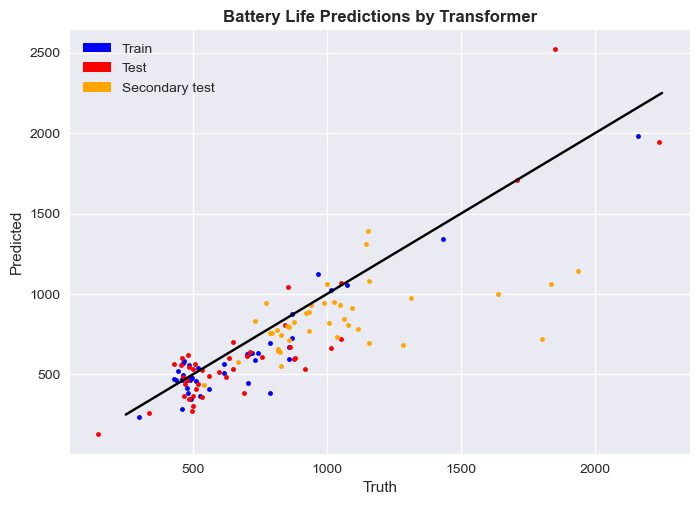

In [155]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)